<a href="https://colab.research.google.com/github/juanpajedrez/pytorch_learning/blob/main/06_pytorch_transfer_learning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#06. Pytorch Transfer Learning

What is transfer learning?

Transfer learning involves takes the parameters of what one model has learned on another dataset and applying them to our own problem.

* Pretrained model = foundation models.

In [39]:
import torch
import torchvision

print(torch.__version__) # Want 1.12+
print(torchvision.__version__) # Want 0.13+

2.8.0+cu126
0.23.0+cu126


### Not necessary

We are in 2025-10-24. We have versions waaay higher, so we are ok :)

Now we've got the versions of torch and torchvision, we would download our codes from previous sections from going_modular, so we don't have to write it all again.

In [40]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [41]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
!nvidia-smi

Thu Oct 30 04:04:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             27W /   70W |     790MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [43]:
import os
import zipfile

from pathlib import Path
import requests

#Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, donwload it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping redownload.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  #Download Pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


data/pizza_steak_sushi directory exists, skipping redownload.


In [44]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and `create_dataloaders()` function we made in 05. Time to use them.

There's one thing we have to think about about handling data: how to **transform** it?

With `torchvision` 0.13+ we can do two ways:
1. Manually created transforms. - You define what transforms to use.
2. Automatically created transforms. - The transforms for your data are defined by the model used.

Important point: When using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation).

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

In [45]:
from torchvision import transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize image to 224, 225
    transforms.ToTensor(), # get images into range [0, 1]
    normalize # make sure images have the same distributions as Imagenet (where pretrained models are trained).
])


In [46]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir = test_dir,
                                                                                transform = manual_transform,
                                                                                batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bc79e47f3e0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you are using.

In [47]:
import torch
torch.__version__

'2.8.0+cu126'

In [48]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'Defaults' = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [49]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [50]:
# Create Dataloaders using automatic transforns
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bc791e11d30>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries.
2. Libraries like `timm` (torch image models).
3. Huggingface Hub (for plenty of different models).`
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1  Which pretrained model should you usr?

*Experiment, experimient, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chose problem (e.g. how well does it classify images for FoodVision mini).

Where does the model live?

Is it on device? (like a self-driving car).

Looking at: https://docs.pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

which model should we chose?

For our case (deplying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.

### 3.2 Setting up a pretrained model

Let's create an instance of EfficientNetB0.

Link: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [51]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained = True).to(device)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [52]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [53]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [54]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [55]:
# Print a summary with torchinfo
from torchinfo import summary

summary(model = model,
        input_size=(1, 3, 224, 224), # Example of [batch_size, color_channels, height, width]))
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundational model and update the output layers to suit yout own problem.

In [56]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [57]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # Feature vector coming in
              out_features=len(class_names), # How many classes do we have? 3!
              bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [58]:
summary(model = model,
        input_size=(1, 3, 224, 224), # Example of [batch_size, color_channels, height, width]))
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [59]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

## 5. Evaluate model by ploting loss curves

In [61]:
try:
  from helper_functions import plot_loss_curves
  print("failed")
except:
  import requests
  print("[INFO] Couldn't find helper_functions.py, downloading it...")
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/helper_functions.py")
    f.write(request.content)

  from helper_functions import plot_loss_curves

failed


Let's see if we have an ideal loss curve:
https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

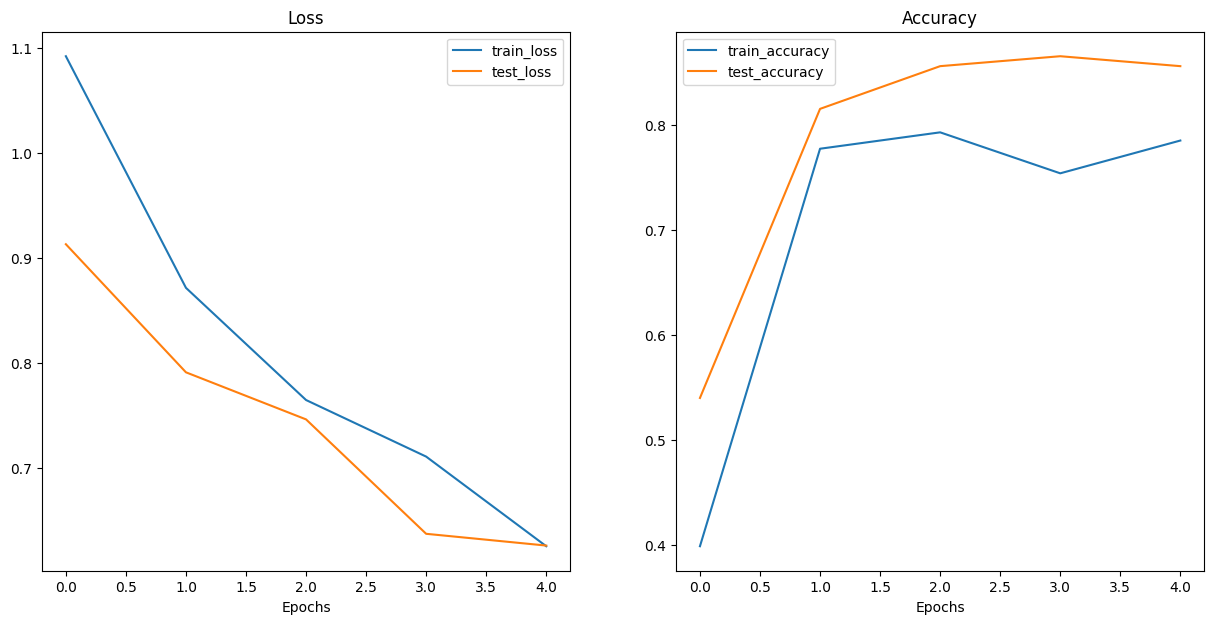

In [62]:
# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motto of *visualize, visualize, visualize*!

And make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure thaty our test/custom data is:
* Same shape - images need to be same shape as model was trained on.
* Same datatype -  custom data should be in the same data type.
* Same device - custom data/test data should be on the same device as the model.
* Same transform -  if you've transformed your custom data, ideally you will transform the test data and custom data the same.

To do all of this automatically, let's create a function called `pred_and_plot_image()`:

The function will be similar to the one here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform, and a target device.
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist.
4. Make sure the model is on the target device.
5. Turn the model to `model.eval()` model to make sure it's ready for inference (this will turn off things like `nn.Dropout()` )
6. Transform the target image and make sure its dimensionality is suited for the mdoel (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model.
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the ttitle to the prediction label from step 9 and prediction probability from step 8.


In [63]:
from typing import List, Tuple
from torchvision import transforms
from PIL import Image

#1. Take in a rained model...
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform:torchvision.transforms = None,
                        device: torch.device = device):
  # 2. Open the Image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
        ]
    )

  ### Predict on image ###
  # 4. Make sure the model is inside the device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim = 0)

    # 7. Make a predction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert model's logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  # 9. Convert pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  # 10. Plot the image and set title to the prediction label
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

In [64]:
# Get a random list subset of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
len(test_image_path_list)

75

In [65]:
test_image_path_sample = random.sample(population = test_image_path_list,
                                      k=num_images_to_plot)
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg')]

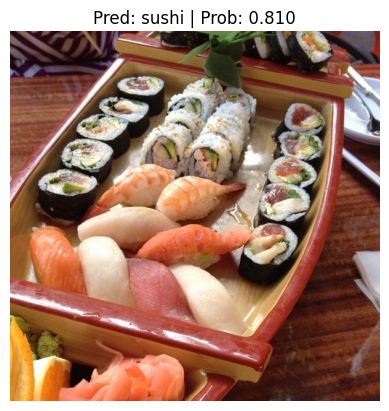

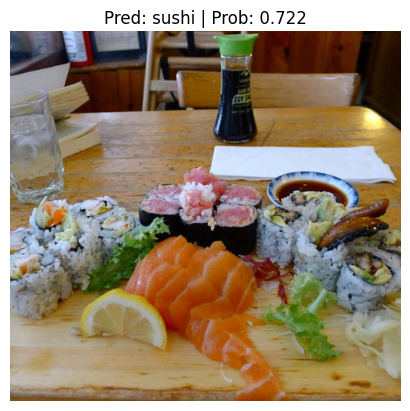

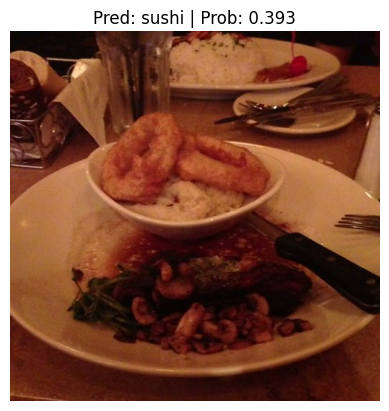

In [66]:
# Make prediction on the plot images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224, 224))

### 6.1 Making predictions on a custom image

Let's make a prediction on the pizza dad image - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg

In [69]:
# Donwload the image
import requests

#setup the custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

#Donwload the image if it doesnt exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    #Donwload the image from Github with "raw" link
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Download {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

Download data/04-pizza-dad.jpeg...


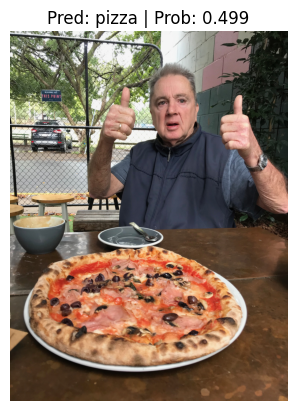

In [71]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names = class_names)